In [3]:
from scipy.io import netcdf, loadmat
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from IPython.display import display, Math, Latex
sys.path.append('/noc/users/am8e13/Python/python_functions/')
from barotropic import *
#from Variable_button import *

In [4]:
def volume_calc(res):
    if res == 36:
        x="/scratch/general/am8e13/results36km"
    elif res == 18:
        x="/scratch/general/am8e13/results18km"
    
    os.chdir(x)
    file2read = netcdf.NetCDFFile("grid.nc",'r')
    hfacw = file2read.variables['HFacW']
    hfacw = hfacw[:]*1
    dyG = file2read.variables['dyG']
    dyG = dyG[:]*1   
    dxG = file2read.variables['dxG']
    dxG = dxG[:]*1  
    
    hfacs = file2read.variables['HFacS']
    hfacs = hfacs[:]*1
    dyU = file2read.variables['dyU']
    dyU = dyU[:]*1
    dxV = file2read.variables['dxV']
    dxV = dxV[:]*1    
    drf = file2read.variables['drF']
    drf = drf[:]*1
    
    # uFlux = uVel(i,j,k,bi,bj)*hFacW(i,j,k,bi,bj)*dyG(i,j,bi,bj)*drF(k)
    # vFlux = vVel(i,j,k,bi,bj)*hFacS(i,j,k,bi,bj)*dyG(i,j,bi,bj)*drF(k)
    
    # Volume calculation  
    dydz_u = np.zeros_like(hfacw)                                                                                             
    for i in range(dyG.shape[0]-1):
        for j in range(dyG.shape[1]):
            for k in range(drf.shape[0]):
                dydz_u[k,i,j] = drf[k]*dyG[i,j]*hfacw[k,i,j]
    
    dydz_v = np.zeros_like(hfacs)                                                                                             
    for i in range(dyG.shape[0]):
        for j in range(dyG.shape[1]-1):
            for k in range(drf.shape[0]):
                dydz_v[k,i,j] = drf[k]*dyG[i,j]*hfacs[k,i,j]  
                
    dxdz_u = np.zeros_like(hfacw)                                                                                             
    for i in range(dxG.shape[0]-1):
        for j in range(dxG.shape[1]):
            for k in range(drf.shape[0]):
                dxdz_u[k,i,j] = drf[k]*dxG[i,j]*hfacw[k,i,j]
                
    dxdz_v = np.zeros_like(hfacs)                                                                                             
    for i in range(dxV.shape[0]):
        for j in range(dxV.shape[1]-1):
            for k in range(drf.shape[0]):
                dxdz_v[k,i,j] = drf[k]*dxG[i,j]*hfacs[k,i,j]
    
    return dydz_u, dydz_v, dxdz_u, dxdz_v

dydz_u_18, dydz_v_18, dxdz_u_18, dxdz_v_18 = volume_calc(18)
dydz_u_36, dydz_v_36, dxdz_u_36, dxdz_v_36 = volume_calc(36)

def volume_selection(res):
    if res == 18:
        dydz_u = dydz_u_18 
        dydz_v = dydz_v_18
        dxdz_u = dxdz_u_18
        dxdz_v = dxdz_v_18
    elif res == 36:
        dydz_u = dydz_u_36 
        dydz_v = dydz_v_36
        dxdz_u = dxdz_u_36
        dxdz_v = dxdz_v_36    
    
    return dydz_u, dydz_v, dxdz_u, dxdz_v

In [5]:
def calculate_fluxes_ob(uvel,vvel,res):
    
    dydz_u, dydz_v, dxdz_u, dxdz_v = volume_selection(res)
    
    if res == 18:
        nx = 420
        ny = 384
    elif res == 36:
        nx = 210
        ny = 192
        
    Wv_flux = np.zeros(uvel.shape[0])
    Wu_flux = np.zeros(uvel.shape[0])
    Ev_flux = np.zeros(uvel.shape[0])
    Eu_flux = np.zeros(uvel.shape[0])
    Nv_flux = np.zeros(uvel.shape[0])
    Nu_flux = np.zeros(uvel.shape[0])
    
    for t in range(uvel.shape[0]):    
        Wv_flux[t] = np.mean(np.sum(vvel[t,:,:,1]*dydz_v[:,0:ny+1,0])) ;
        Wu_flux[t] = np.mean(np.sum(uvel[t,:,:,1]*dydz_u[:,0:ny,1])) ;
        Ev_flux[t] = np.mean(np.sum(vvel[t,:,:,nx-1]*dydz_v[:,0:ny+1,nx-1])) ;
        Eu_flux[t] = np.mean(np.sum(uvel[t,:,:,nx-1]*dydz_u[:,0:ny,nx-1])) ;
        Nv_flux[t] = np.mean(np.sum(vvel[t,:,ny-1,:]*dxdz_v[:,ny-1,0:nx])) ;
        Nu_flux[t] = np.mean(np.sum(uvel[t,:,ny-1,0:nx]*dxdz_u[:,ny-1,0:nx])) ;
        
    return Wv_flux, Wu_flux, Ev_flux, Eu_flux, Nv_flux, Nu_flux

In [6]:
# Bathy is 1 on land and 0 over sea
x="/scratch/general/am8e13/results36km"
os.chdir(x) 
file2read = netcdf.NetCDFFile("grid.nc",'r')
Depth=file2read.variables['Depth']
Depth=Depth[:]*1
Zp1 = file2read.variables['Zp1']
Zp1 = Zp1[:]*1
bathy=file2read.variables['HFacC']
bathy=bathy[:]*1
bathy[bathy==0]=-1
bathy[bathy>0]=0
bathy[bathy==-1]=1

bathy1 = bathy[0,:,:]

In [7]:
# Bathy is 1 on land and 0 over sea
x="/scratch/general/am8e13/results18km"
os.chdir(x) 
file2read = netcdf.NetCDFFile("grid.nc",'r')
Depth18km=file2read.variables['Depth']
Depth18km=Depth18km[:]*1
Zp118km = file2read.variables['Zp1']
Zp118km = Zp118km[:]*1
bathy18km=file2read.variables['HFacC']
bathy18km=bathy18km[:]*1
bathy18km[bathy18km==0]=-1
bathy18km[bathy18km>0]=0
bathy18km[bathy18km==-1]=1

bathy118km = bathy18km[0,:,:]

In [8]:
def monitor_extract(x,iter_list):
    os.chdir(x)
    theta_mean_tot =[]
    theta_max_tot =[]
    theta_min_tot =[]
    eta_mean_tot =[]
    eta_max_tot =[]
    eta_min_tot =[]
    salt_mean_tot =[]
    salt_max_tot =[]
    salt_min_tot =[]
    sss_mean_tot =[]
    sss_max_tot =[]
    sss_min_tot =[]
    sst_mean_tot =[]
    sst_max_tot =[]
    sst_min_tot =[]
    vvel_mean_tot =[]
    vvel_max_tot =[]
    vvel_min_tot =[]
    uvel_mean_tot =[]
    uvel_max_tot =[]
    uvel_min_tot =[]
    ke_mean_tot =[]
    ke_max_tot =[]
    ke_vol_tot =[]
    seaice_area_max_tot = []
    seaice_area_min_tot = []
    seaice_area_mean_tot = []
    seaice_heff_max_tot = []
    seaice_heff_min_tot = []
    seaice_heff_mean_tot = []
    time_seconds_tot = []
    
    
    for iter in iter_list:
        zerosto_add = '0'
        for zeros in range(9 - len(str(iter))):
            zerosto_add = '0'+zerosto_add
        
        file2read = netcdf.NetCDFFile("monitor."+zerosto_add+str(iter)+".t001.nc",'r')
        file2read3 = netcdf.NetCDFFile("monitor_seaice."+zerosto_add+str(iter)+".t001.nc",'r')

        
        time_seconds = file2read.variables['time_secondsf']
        time_seconds=time_seconds[:]*1    
        theta_mean=file2read.variables['dynstat_theta_mean']
        theta_mean=theta_mean[:]*1    
        theta_max=file2read.variables['dynstat_theta_max']
        theta_max=theta_max[:]*1
        theta_min=file2read.variables['dynstat_theta_min']
        theta_min=theta_min[:]*1    
        salt_mean=file2read.variables['dynstat_salt_mean']
        salt_mean=salt_mean[:]*1
        salt_max=file2read.variables['dynstat_salt_max']
        salt_max=salt_max[:]*1
        salt_min=file2read.variables['dynstat_salt_min']
        salt_min=salt_min[:]*1    
        sst_mean=file2read.variables['dynstat_sst_mean']
        sst_mean=sst_mean[:]*1
        sst_max=file2read.variables['dynstat_sst_max']
        sst_max=sst_max[:]*1
        sst_min=file2read.variables['dynstat_sst_max']
        sst_min=sst_min[:]*1    
        sss_mean=file2read.variables['dynstat_sss_mean']
        sss_mean=sss_mean[:]*1
        sss_mim=file2read.variables['dynstat_sss_min']
        sss_min=sss_mean[:]*1
        sss_max=file2read.variables['dynstat_sss_max']
        sss_max=sss_max[:]*1    
        eta_mean=file2read.variables['dynstat_eta_mean']
        eta_mean=eta_mean[:]*1
        eta_min=file2read.variables['dynstat_eta_min']
        eta_min=eta_min[:]*1
        eta_max=file2read.variables['dynstat_eta_max']
        eta_max=eta_max[:]*1    
        uvel_mean=file2read.variables['dynstat_uvel_mean']
        uvel_mean=uvel_mean[:]*1
        uvel_max=file2read.variables['dynstat_uvel_max']
        uvel_max=uvel_max[:]*1
        uvel_min=file2read.variables['dynstat_uvel_min']
        uvel_min=uvel_min[:]*1    
        vvel_mean=file2read.variables['dynstat_vvel_mean']
        vvel_mean=vvel_mean[:]*1
        vvel_max=file2read.variables['dynstat_vvel_max']
        vvel_max=vvel_max[:]*1
        vvel_min=file2read.variables['dynstat_vvel_min']
        vvel_min=vvel_min[:]*1    
        ke_mean=file2read.variables['ke_mean']
        ke_mean=ke_mean[:]*1
        ke_max=file2read.variables['ke_max']
        ke_max=ke_max[:]*1
        ke_vol=file2read.variables['ke_vol']
        ke_vol=ke_vol[:]*1    
        seaice_area_max = file2read3.variables['seaice_area_max']
        seaice_area_max = seaice_area_max[:]*1
        seaice_area_min = file2read3.variables['seaice_area_min']
        seaice_area_min = seaice_area_min[:]*1
        seaice_area_mean = file2read3.variables['seaice_area_mean']
        seaice_area_mean = seaice_area_mean[:]*1
        seaice_heff_max = file2read3.variables['seaice_heff_max']
        seaice_heff_max = seaice_heff_max[:]*1
        seaice_heff_min = file2read3.variables['seaice_heff_min']
        seaice_heff_min = seaice_heff_min[:]*1
        seaice_heff_mean = file2read3.variables['seaice_heff_mean']
        seaice_heff_mean = seaice_heff_mean[:]*1
    
        seaice_area_max_tot =np.concatenate([seaice_area_max_tot , seaice_area_max])
        seaice_area_min_tot = np.concatenate([seaice_area_min_tot , seaice_area_min])
        seaice_area_mean_tot =np.concatenate([seaice_area_mean_tot , seaice_area_mean])    
        seaice_heff_max_tot =np.concatenate([seaice_heff_max_tot , seaice_heff_max])
        seaice_heff_min_tot = np.concatenate([seaice_heff_min_tot , seaice_heff_min])
        seaice_heff_mean_tot =np.concatenate([seaice_heff_mean_tot , seaice_heff_mean])        
        time_seconds_tot =np.concatenate([time_seconds_tot , time_seconds])
        theta_mean_tot =np.concatenate([theta_mean_tot , theta_mean])
        theta_min_tot = np.concatenate([theta_min_tot , theta_min])
        theta_max_tot =np.concatenate([theta_max_tot , theta_max])    
        salt_mean_tot =np.concatenate([salt_mean_tot , salt_mean])
        salt_min_tot =np.concatenate([salt_min_tot , salt_min])
        salt_max_tot =np.concatenate([salt_max_tot , salt_max])
        sst_mean_tot =np.concatenate([sst_mean_tot , sst_mean])
        sst_min_tot =np.concatenate([sst_min_tot , sst_min])
        sst_max_tot =np.concatenate([sst_max_tot , sst_max])    
        sss_mean_tot =np.concatenate([sss_mean_tot , sss_mean])
        sss_min_tot =np.concatenate([sss_min_tot , sss_min])
        sss_max_tot =np.concatenate([sss_max_tot , sss_max])    
        vvel_mean_tot =np.concatenate([vvel_mean_tot , vvel_mean])
        vvel_min_tot =np.concatenate([vvel_min_tot , vvel_min])
        vvel_max_tot =np.concatenate([vvel_max_tot , vvel_max])    
        uvel_mean_tot =np.concatenate([uvel_mean_tot , uvel_mean])
        uvel_min_tot =np.concatenate([uvel_min_tot , uvel_min])
        uvel_max_tot =np.concatenate([uvel_max_tot , uvel_max])
        eta_mean_tot =np.concatenate([eta_mean_tot , eta_mean])
        eta_min_tot = np.concatenate([eta_min_tot , eta_min])
        eta_max_tot =np.concatenate([eta_max_tot , eta_max])
        ke_mean_tot =np.concatenate([ke_mean_tot , ke_mean])
        ke_vol_tot = np.concatenate([ke_vol_tot , ke_vol])
        ke_max_tot =np.concatenate([ke_max_tot , ke_max])
    
    #averages
    ave_theta_mean = np.zeros(32)
    ave_sss_mean = np.zeros(32)
    ave_sst_mean = np.zeros(32)
    for i in range(32):
        ave_theta_mean[i] = np.mean(theta_mean_tot[i*36+0:i*36+36])
        ave_sss_mean[i] = np.mean(sss_mean_tot[i*36+0:i*36+36])
        ave_sst_mean[i] = np.mean(sst_mean_tot[i*36+0:i*36+36])
        
    return     theta_mean_tot, theta_max_tot, theta_min_tot, eta_mean_tot, eta_max_tot, eta_min_tot, \
                salt_mean_tot, salt_max_tot, salt_min_tot, sss_mean_tot, sss_max_tot, sss_min_tot, \
                sst_mean_tot, sst_max_tot, sst_min_tot, vvel_mean_tot, vvel_max_tot, vvel_min_tot, \
                uvel_mean_tot, uvel_max_tot, uvel_min_tot, ke_mean_tot, ke_max_tot, ke_vol_tot, \
                seaice_area_max_tot, seaice_area_min_tot, seaice_area_mean_tot, seaice_heff_max_tot, \
                seaice_heff_min_tot, seaice_heff_mean_tot, time_seconds_tot

In [9]:
theta_mean_new, theta_max_new, theta_min_new, eta_mean_new, eta_max_new, eta_min_new, \
    salt_mean_new, salt_max_new, salt_min_new, sss_mean_new, sss_max_new, sss_min_new, \
    sst_mean_new, sst_max_new, sst_min_new, vvel_mean_new, vvel_max_new, vvel_min_new, \
    uvel_mean_new, uvel_max_new, uvel_min_new, ke_mean_new, ke_max_new, ke_vol_new, \
    seaice_area_max_new, seaice_area_min_new, seaice_area_mean_new, seaice_heff_max_new, \
    seaice_heff_min_new, seaice_heff_mean_new, time_seconds_new = \
    monitor_extract('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_ERA/results/',[0,518400,1036800])

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


In [10]:
theta_mean_new2, theta_max_new2, theta_min_new2, eta_mean_new2, eta_max_new2, eta_min_new2, \
    salt_mean_new2, salt_max_new2, salt_min_new2, sss_mean_new2, sss_max_new2, sss_min_new2, \
    sst_mean_new2, sst_max_new2, sst_min_new2, vvel_mean_new2, vvel_max_new2, vvel_min_new2, \
    uvel_mean_new2, uvel_max_new2, uvel_min_new2, ke_mean_new2, ke_max_new2, ke_vol_new2, \
    seaice_area_max_new2, seaice_area_min_new2, seaice_area_mean_new2, seaice_heff_max_new2, \
    seaice_heff_min_new2, seaice_heff_mean_new2, time_seconds_new2 = \
    monitor_extract('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_newdownloaded_obcs/results/',[0,518400,1036800])

In [11]:
theta_mean_first, theta_max_first, theta_min_first, eta_mean_first, eta_max_first, eta_min_first,\
    salt_mean_first, salt_max_first, salt_min_first, sss_mean_first, sss_max_first, sss_min_first,\
    sst_mean_first, sst_max_first, sst_min_first, vvel_mean_first, vvel_max_first, vvel_min_first,\
    uvel_mean_first, uvel_max_first, uvel_min_first, ke_mean_first, ke_max_first, ke_vol_first,\
    seaice_area_max_first, seaice_area_min_first, seaice_area_mean_first, seaice_heff_max_first, \
    seaice_heff_min_first, seaice_heff_mean_first, time_seconds_first = \
    monitor_extract('/scratch/general/am8e13/results_first/',[0,262800,459900])

In [12]:
theta_mean_newobs3, theta_max_newobs3, theta_min_newobs3, eta_mean_newobs3, eta_max_newobs3, eta_min_newobs3, \
    salt_mean_newobs3, salt_max_newobs3, salt_min_newobs3, sss_mean_newobs3, sss_max_newobs3, sss_min_newobs3, \
    sst_mean_newobs3, sst_max_newobs3, sst_min_newobs3, vvel_mean_newobs3, vvel_max_newobs3, vvel_min_newobs3, \
    uvel_mean_newobs3, uvel_max_newobs3, uvel_min_newobs3, ke_mean_newobs3, ke_max_newobs3, ke_vol_newobs3, \
    seaice_area_max_newobs3, seaice_area_min_newobs3, seaice_area_mean_newobs3, seaice_heff_max_newobs3, \
    seaice_heff_min_newobs3, seaice_heff_mean_newobs3, time_seconds_newobs3 = \
    monitor_extract('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_ERA_notemp_salt/results/',[0,518400,1036800])

In [13]:
theta_mean_new4, theta_max_new4, theta_min_new4, eta_mean_new4, eta_max_new4, eta_min_new4, \
    salt_mean_new4, salt_max_new4, salt_min_new4, sss_mean_new4, sss_max_new4, sss_min_new4, \
    sst_mean_new4, sst_max_new4, sst_min_new4, vvel_mean_new4, vvel_max_new4, vvel_min_new4, \
    uvel_mean_new4, uvel_max_new4, uvel_min_new4, ke_mean_new4, ke_max_new4, ke_vol_new4, \
    seaice_area_max_new4, seaice_area_min_new4, seaice_area_mean_new4, seaice_heff_max_new4, \
    seaice_heff_min_new4, seaice_heff_mean_new4, time_seconds_new4 = \
    monitor_extract('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_ERA_noobcs/results/',[0,518400,1036800])

Green=old run, Blue=average obcs, yellow=average obcs 18km, Red=zeroflux obcs


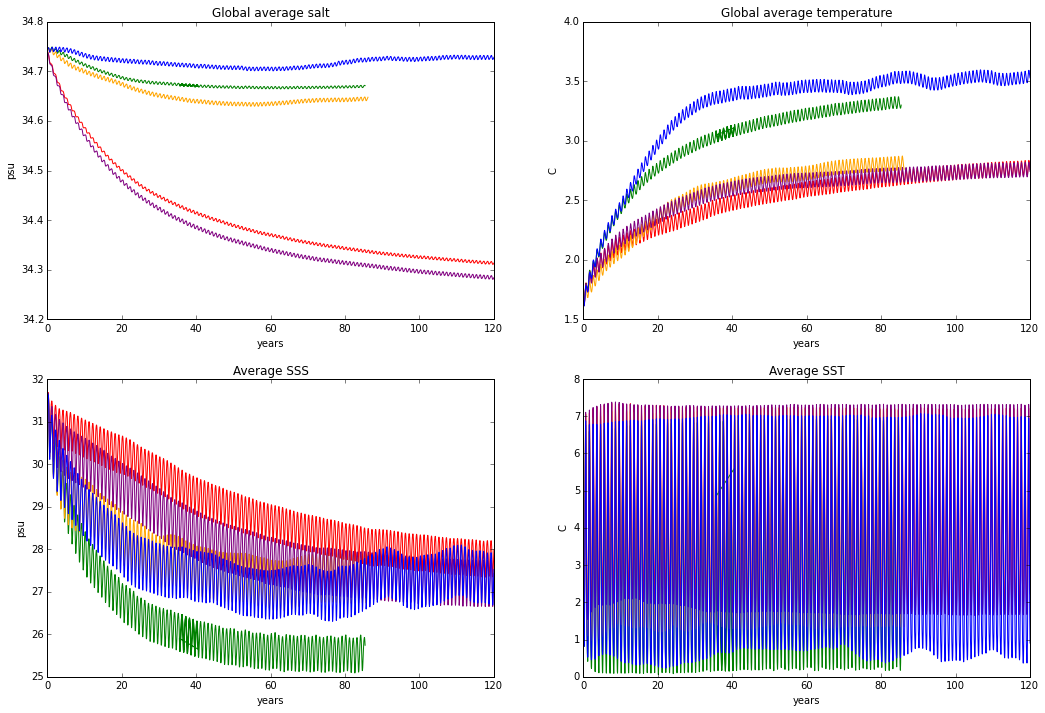

In [14]:
# free-surface_anomaly evolution
fig, axes = plt.subplots(nrows=2, ncols=2)
time_new = (time_seconds_new - time_seconds_new[0])/(360*60*60*24)
time_new2 = (time_seconds_new2 - time_seconds_new2[0])/(360*60*60*24)
time_first = (time_seconds_first - time_seconds_first[0])/(360*60*60*24)
time_newobs3 = (time_seconds_newobs3 - time_seconds_newobs3[0])/(360*60*60*24)
time_new4 = (time_seconds_new4 - time_seconds_new4[0])/(360*60*60*24)

axes[0,0].plot(time_first,salt_mean_first,'g')
axes[0,0].plot(time_newobs3,salt_mean_newobs3,'orange')
axes[0,0].plot(time_new2,salt_mean_new2,'r')
axes[0,0].plot(time_new4,salt_mean_new4,'purple')
axes[0,0].set_title('Salt average')
axes[0,0].set_title('Global average salt')
axes[0,0].set_ylabel('psu')
axes[0,0].set_xlabel('years')
axes[0,0].plot(time_new,salt_mean_new)
     

axes[0,1].plot(time_new2,theta_mean_new2,'r')
axes[0,1].plot(time_first,theta_mean_first,'g')
axes[0,1].plot(time_newobs3,theta_mean_newobs3,'orange')
axes[0,1].plot(time_new4,theta_mean_new4,'purple')
axes[0,1].set_ylabel('C')
axes[0,1].set_xlabel('years')
axes[0,1].set_title('Global average temperature')
axes[0,1].plot(time_new,theta_mean_new)


axes[1,0].plot(time_new2,sss_mean_new2,'r')
axes[1,0].plot(time_first,sss_mean_first,'g')
axes[1,0].plot(time_newobs3,sss_mean_newobs3,'orange')
axes[1,0].plot(time_new4,sss_mean_new4,'purple')
axes[1,0].set_xlabel('years')
axes[1,0].set_title('Average SSS')
axes[1,0].set_ylabel('psu')
axes[1,0].plot(time_new,sss_mean_new)


axes[1,1].plot(time_new2,sst_mean_new2,'r')
axes[1,1].plot(time_first,sst_mean_first,'g')
axes[1,1].plot(time_newobs3,sst_mean_newobs3,'orange')
axes[1,1].plot(time_new4,sst_mean_new4,'purple')
axes[1,1].set_xlabel('years')
axes[1,1].set_title('Average SST')
axes[1,1].set_ylabel('C')
axes[1,1].plot(time_new,sst_mean_new)

fig.subplots_adjust(right=2.4,top=2.4)
print 'Green=old run, Blue=average obcs, yellow=average obcs 18km, Red=zeroflux obcs'

Green=old run, Blue=average obcs, yellow=average obcs 18km, Red=zeroflux obcs


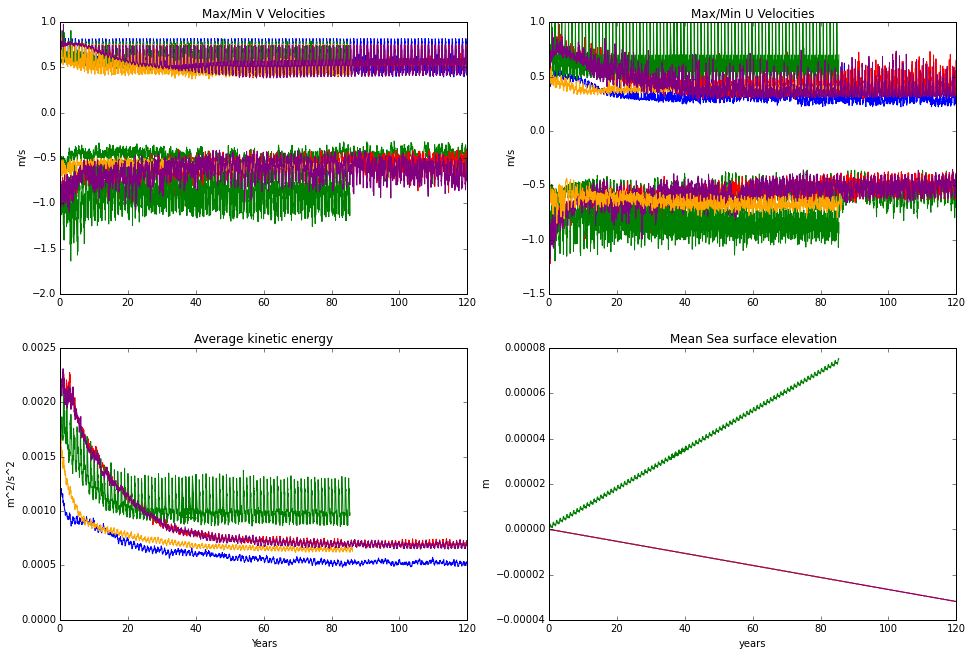

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0,0].plot(time_new,vvel_max_new)
axes[0,0].plot(time_new2,vvel_max_new2,'r')
axes[0,0].plot(time_first,vvel_max_first,'g')
axes[0,0].plot(time_newobs3,vvel_max_newobs3,'orange')
axes[0,0].plot(time_new4,vvel_max_new4,'purple')
axes[0,0].plot(time_new,vvel_min_new)
axes[0,0].plot(time_new2,vvel_min_new2,'r')
axes[0,0].plot(time_first,vvel_min_first,'g')
axes[0,0].plot(time_newobs3,vvel_min_newobs3,'orange')
axes[0,0].plot(time_new4,vvel_min_new4,'purple')
axes[0,0].set_title('Max/Min V Velocities ')
axes[0,0].set_ylabel('m/s')

axes[0,1].plot(time_new,uvel_max_new)
axes[0,1].plot(time_new2,uvel_max_new2,'r')
axes[0,1].plot(time_first,uvel_max_first,'g')
axes[0,1].plot(time_newobs3,uvel_max_newobs3,'orange')
axes[0,1].plot(time_new4,uvel_max_new4,'purple')
axes[0,1].plot(time_new,uvel_min_new)
axes[0,1].plot(time_new2,uvel_min_new2,'r')
axes[0,1].plot(time_first,uvel_min_first,'g')
axes[0,1].plot(time_new4,uvel_min_new4,'purple')
axes[0,1].plot(time_newobs3,uvel_min_newobs3,'orange')
axes[0,1].set_title('Max/Min U Velocities ')
axes[0,1].set_ylabel('m/s')

axes[1,0].plot(time_new,ke_mean_new)
axes[1,0].plot(time_new2,ke_mean_new2,'r')
axes[1,0].plot(time_first,ke_mean_first,'g')
axes[1,0].plot(time_newobs3,ke_mean_newobs3,'orange')
axes[1,0].plot(time_new4,ke_mean_new4,'purple')
axes[1,0].set_title('Average kinetic energy')
axes[1,0].set_ylabel('m^2/s^2')
axes[1,0].set_xlabel('Years')

#axes[1,1].plot(time_new,eta_mean_new)
axes[1,1].plot(time_new2,eta_mean_new2,'r')
axes[1,1].plot(time_first,eta_mean_first,'g')
axes[1,1].plot(time_newobs3,eta_mean_newobs3,'orange')
axes[1,1].plot(time_new4,eta_mean_new4,'purple')
axes[1,1].set_title('Mean Sea surface elevation ')
axes[1,1].set_ylabel('m')
axes[1,1].set_xlabel('years')

fig.subplots_adjust(right=2.2,top=2.2)
print 'Green=old run, Blue=average obcs, yellow=average obcs 18km, Red=zeroflux obcs'

Green=old run, Blue=average obcs, yellow=average obcs 18km, Red=zeroflux obcs


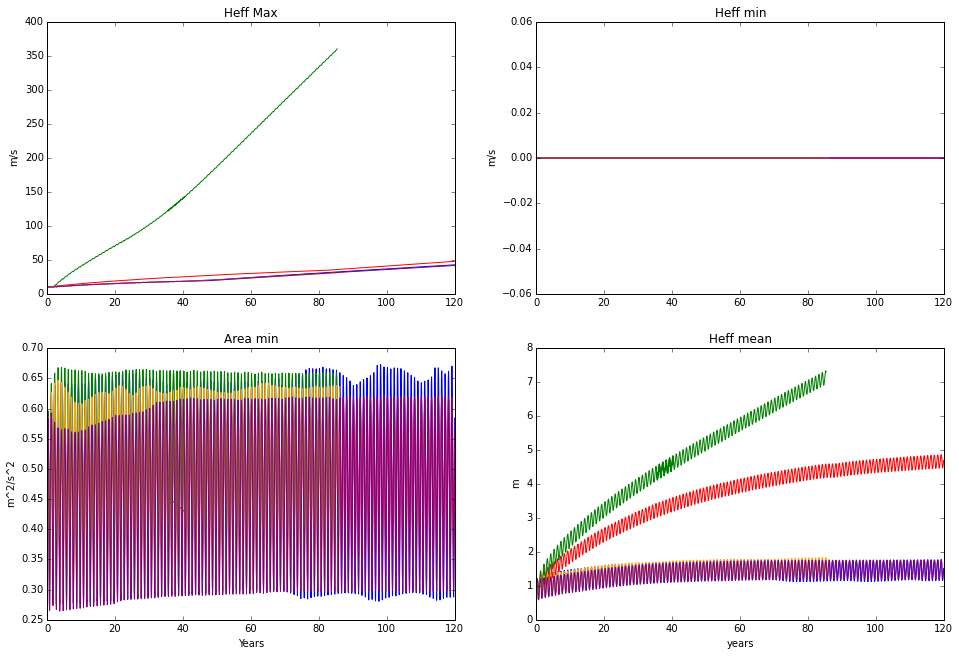

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2)
#time_newobs3 = time_newobs3[0:1442]
axes[0,0].plot(time_new,seaice_heff_max_new)
axes[0,0].plot(time_new2,seaice_heff_max_new2,'r')
axes[0,0].plot(time_first,seaice_heff_max_first,'g')
axes[0,0].plot(time_newobs3,seaice_heff_max_newobs3,'orange')
axes[0,0].plot(time_new4,seaice_heff_max_new4,'purple')
axes[0,0].set_title('Heff Max ')
axes[0,0].set_ylabel('m/s')

axes[0,1].plot(time_new,seaice_heff_min_new)
axes[0,1].plot(time_new2,seaice_heff_min_new2,'r')
axes[0,1].plot(time_first,seaice_heff_min_first,'g')
axes[0,1].plot(time_newobs3,seaice_heff_min_newobs3,'orange')
axes[0,1].plot(time_new4,seaice_heff_min_new4,'purple')
axes[0,1].set_title('Heff min ')
axes[0,1].set_ylabel('m/s')

axes[1,0].plot(time_new,seaice_area_mean_new)
axes[1,0].plot(time_new2,seaice_area_mean_new2,'r')
axes[1,0].plot(time_first,seaice_area_mean_first,'g')
axes[1,0].plot(time_newobs3,seaice_area_mean_newobs3,'orange')
axes[1,0].plot(time_new4,seaice_area_mean_new4,'purple')
axes[1,0].set_title('Area min')
axes[1,0].set_ylabel('m^2/s^2')
axes[1,0].set_xlabel('Years')

axes[1,1].plot(time_new,seaice_heff_mean_new)
axes[1,1].plot(time_new2,seaice_heff_mean_new2,'r')
axes[1,1].plot(time_first,seaice_heff_mean_first,'g')
axes[1,1].plot(time_newobs3,seaice_heff_mean_newobs3,'orange')
axes[1,1].plot(time_new4,seaice_heff_mean_new4,'purple')
axes[1,1].set_title('Heff mean ')
axes[1,1].set_ylabel('m')
axes[1,1].set_xlabel('years')

fig.subplots_adjust(right=2.2,top=2.2)
print 'Green=old run, Blue=average obcs, yellow=average obcs 18km, Red=zeroflux obcs'

In [ ]:
x="/scratch/general/am8e13/results_first/"
os.chdir(x)                                                                                                                                                                                                                  
file2read = netcdf.NetCDFFile("state.nc",'r')
T_first=file2read.variables['Temp']
T_first=T_first[:]*1
V_first=file2read.variables['V']
V_first=V_first[:]*1
U_first=file2read.variables['U']
U_first=U_first[:]*1
days_first=file2read.variables['T']
days_first=days_first[:]*1

psi_first = baro_stream(U_first)

psi_mean_first = np.nanmean(psi_first,axis = 1)
psi_mean_first = np.nanmean(psi_mean_first,axis = 1)
psi_max_first = np.nanmax(psi_first,axis=1)
psi_max_first = np.nanmax(psi_max_first,axis=1)
psi_min_first = np.nanmin(psi_first,axis=1)
psi_min_first = np.nanmin(psi_min_first,axis=1)

In [ ]:
#x="/scratch/general/am8e13/results_newspinup/"
x = "/hpcdata/scratch/am8e13/cs_36km_tutorial/run_ERA/results/"
os.chdir(x)                                                                                                                                                                                                                  
file2read = netcdf.NetCDFFile("state.nc",'r')
T_newspinup1=file2read.variables['Temp']
T_newspinup1=T_newspinup1[:]*1
V_newspinup1=file2read.variables['V']
V_newspinup1=V_newspinup1[:]*1
U_newspinup1=file2read.variables['U']
U_newspinup1=U_newspinup1[:]*1
days_newspinup1=file2read.variables['T']
days_newspinup1=days_newspinup1[:]*1

psi_newspinup1 = baro_stream(U_newspinup1)

psi_mean_newspinup1 = np.nanmean(psi_newspinup1,axis = 1)
psi_mean_newspinup1 = np.nanmean(psi_mean_newspinup1,axis = 1)
psi_max_newspinup1 = np.nanmax(psi_newspinup1,axis=1)
psi_max_newspinup1 = np.nanmax(psi_max_newspinup1,axis=1)
psi_min_newspinup1 = np.nanmin(psi_newspinup1,axis=1)
psi_min_newspinup1 = np.nanmin(psi_min_newspinup1,axis=1)

In [ ]:
#x="/scratch/general/am8e13/results_newobcs_NuWv/"
x="/hpcdata/scratch/am8e13/cs_36km_tutorial/run_ERA_noobcs/results/"
os.chdir(x)                                                                                                                                                                                                                  
file2read = netcdf.NetCDFFile("state.nc",'r')
T_newobs3=file2read.variables['Temp']
T_newobs3=T_newobs3[:]*1
V_newobs3=file2read.variables['V']
V_newobs3=V_newobs3[:]*1
U_newobs3=file2read.variables['U']
U_newobs3=U_newobs3[:]*1
days_newobs3=file2read.variables['T']
days_newobs3=days_newobs3[:]*1

psi_newobs3 = baro_stream(U_newobs3)

psi_mean_newobs3 = np.nanmean(psi_newobs3,axis = 1)
psi_mean_newobs3 = np.nanmean(psi_mean_newobs3,axis = 1)
psi_max_newobs3 = np.nanmax(psi_newobs3,axis=1)
psi_max_newobs3 = np.nanmax(psi_max_newobs3,axis=1)
psi_min_newobs3 = np.nanmin(psi_newobs3,axis=1)
psi_min_newobs3 = np.nanmin(psi_min_newobs3,axis=1)

In [ ]:
x="/hpcdata/scratch/am8e13/cs_36km_tutorial/run_newdownloaded_obcs/results/"
os.chdir(x)                                                                                                                                                                                                                  
file2read = netcdf.NetCDFFile("state.nc",'r')
T_newobs2=file2read.variables['Temp']
T_newobs2=T_newobs2[:]*1
V_newobs2=file2read.variables['V']
V_newobs2=V_newobs2[:]*1
U_newobs2=file2read.variables['U']
U_newobs2=U_newobs2[:]*1
days_newobs2=file2read.variables['T']
days_newobs2=days_newobs2[:]*1

psi_newobs2 = baro_stream(U_newobs2)

psi_mean_newobs2 = np.nanmean(psi_newobs2,axis = 1)
psi_mean_newobs2 = np.nanmean(psi_mean_newobs2,axis = 1)
psi_max_newobs2 = np.nanmax(psi_newobs2,axis=1)
psi_max_newobs2 = np.nanmax(psi_max_newobs2,axis=1)
psi_min_newobs2 = np.nanmin(psi_newobs2,axis=1)
psi_min_newobs2 = np.nanmin(psi_min_newobs2,axis=1)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
t = 60*60*24*360
axes[0].plot((days_first[0:360]-days_first[0])/t,psi_mean_first[0:360],'r')
axes[0].plot((days_newspinup1-days_newspinup1[0])/t,psi_mean_newspinup1,'b')
axes[0].plot((days_newobs3-days_newobs3[0])/t,psi_mean_newobs3,'g')
axes[0].plot((days_newobs2-days_newobs2[0])/t,psi_mean_newobs2,'purple')
axes[1].plot((days_first[0:360]-days_first[0])/t,psi_min_first[0:360],'r')
axes[1].plot((days_newspinup1-days_newspinup1[0])/t,psi_min_new,'b')
axes[1].plot((days_newobs3-days_newobs3[0])/t,psi_min_newobs3,'g')
axes[1].plot((days_newob2-days_newobs2[0])/t,psi_min_newobs2,'purple')
axes[1].plot((days_first[0:360]-days_first[0])/t,psi_max_first[0:360],'r')
axes[1].plot((days_newspinup1-days_newspinup1[0])/t,psi_max_newspinup1,'b')
axes[1].plot((days_newobs3-days_newobs3[0])/t,psi_max_newobs3,'g')
axes[1].plot((days_newobs2-days_newobs2[0])/t,psi_max_newobs2,'purple')
axes[0].set_ylabel('Sv')
axes[1].set_ylabel('Sv')
axes[1].set_xlabel('years')
axes[0].set_title('Average Barotropic Streamfunction')
axes[1].set_title('Max/Min Barotropic Streamfunction')

fig.subplots_adjust(right=1.5,top=1.5)

In [ ]:
T_first[:,bathy==1] = np.nan
T_newspinup1[:,bathy==1] = np.nan
#T_newobs[:,bathy==1] = np.nan
T_newobs2[:,bathy==1] = np.nan
T_newobs3[:,bathy==1] = np.nan

In [ ]:
times = [0 , 120 , 240 , 360 , 480 , 700]*8
timesste = np.zeros(6)
for i in range(6):
    timesste[i] = (days_newobs2[times[i]])/(360*24*60*60)

def plot_field_1(field,vimin,vimax,cmap,setbad,unity,origin):
    # Salt contentration evolution
    fig, axes = plt.subplots(nrows=2, ncols=3)
    i=0
    vimin = vimin
    vimax = vimax
    for ax in axes.flat:
        ax.set_title("T = "+str(timesste[i]) +"years")
        masked_array = np.ma.array(field[times[i],:,:], mask=np.isnan(field[times[i],:,:]))
        cmap= cmap
        cmap.set_bad(setbad,1.)
        ca = ax.imshow(masked_array,vmin = vimin, vmax = vimax, interpolation='nearest',cmap = cmap ,origin= origin)
        cbar = fig.colorbar(ca , ax=ax, )
        cbar.ax.set_ylabel(unity)
        i=i+1
    fig.subplots_adjust(right=2.4,top=2)

In [ ]:
times = [0 , 120 , 240 , 360 , 480 , 719]
timesste = np.zeros(6)
for i in range(6):
    timesste[i] = (days_first[times[i]])/(360*24*60*60)

temp  = T_first[:,:,30:120,125]
plot_field_1(temp,0,10,matplotlib.cm.jet,'grey','psu','upper') 

In [ ]:
times = [0 , 240 , 480 , 720 , 960 , 1400]
timesste = np.zeros(6)
for i in range(6):
    timesste[i] = (days_newspinup1[times[i]])/(360*24*60*60)

temp  = T_newspinup1[:,:,30:120,125]
plot_field_1(temp,0,10,matplotlib.cm.jet,'grey','psu','upper') 

In [ ]:
times = [0 , 240 , 480 , 720 , 960 , 1400]
timesste = np.zeros(6)
for i in range(6):
    timesste[i] = (days_newobs2[times[i]])/(360*24*60*60)
    
temp  = T_newobs2[:,:,30:120,125]
plot_field_1(temp,0,10,matplotlib.cm.jet,'grey','psu','upper') 

In [ ]:
times = [0 , 240 , 480 , 720 , 960 , 1400]
timesste = np.zeros(6)
for i in range(6):
    timesste[i] = (days_newobs3[times[i]])/(360*24*60*60)

temp  = T_newobs3[:,:,30:120,125]
plot_field_1(temp,0,10,matplotlib.cm.jet,'grey','psu','upper') 

In [ ]:
times = [0 , 120 , 240 , 360 , 480 , 719]
timesste = np.zeros(6)
for i in range(6):
    timesste[i] = (days_first[times[i]])/(360*24*60*60)

temp  = T_first[:,:,72,0:209]
plot_field_1(temp,0,10,matplotlib.cm.jet,'grey','psu','upper') 

In [ ]:
times = [0 , 240 , 480 , 720 , 960 , 1400]
timesste = np.zeros(6)
for i in range(6):
    timesste[i] = (days_newspinup1[times[i]])/(360*24*60*60)

temp  = T_newspinup1[:,:,72,0:209]
plot_field_1(temp,0,10,matplotlib.cm.jet,'grey','psu','upper') 

In [ ]:
times = [0 , 240 , 480 , 720 , 960 , 1400]
timesste = np.zeros(6)
for i in range(6):
    timesste[i] = (days_newobs2[times[i]])/(360*24*60*60)
    
temp  = T_newobs2[:,:,72,0:209]
plot_field_1(temp,0,10,matplotlib.cm.jet,'grey','psu','upper') 

In [ ]:
times = [0 , 240 , 480 , 720 , 960 , 1400]
timesste = np.zeros(6)
for i in range(6):
    timesste[i] = (days_newobs3[times[i]])/(360*24*60*60)

temp  = T_newobs3[:,:,72,0:209]
plot_field_1(temp,0,10,matplotlib.cm.jet,'grey','psu','upper') 

In [ ]:
def volume_calc(res):
    if res == 36:
        x="/scratch/general/am8e13/results36km"
    elif res == 18:
        x="/scratch/general/am8e13/results18km"
    
    os.chdir(x)
    file2read = netcdf.NetCDFFile("grid.nc",'r')
    hfacw = file2read.variables['HFacW']
    hfacw = hfacw[:]*1
    dyg = file2read.variables['dyG']
    dyg = dyg[:]*1    
    
    hfacs = file2read.variables['HFacS']
    hfacs = hfacs[:]*1
    dyU = file2read.variables['dyU']
    dyU = dyU[:]*1
    dxV = file2read.variables['dxV']
    dxV = dxV[:]*1    
    drf = file2read.variables['drF']
    drf = drf[:]*1
    
    # Volume calculation  
    dydz_u = np.zeros_like(hfacw)                                                                                             
    for i in range(dyU.shape[0]-1):
        for j in range(dyU.shape[1]):
            for k in range(drf.shape[0]):
                dydz_u[k,i,j] = drf[k]*dyU[i,j]*hfacw[k,i,j]
    
    dydz_v = np.zeros_like(hfacs)                                                                                             
    for i in range(dyU.shape[0]):
        for j in range(dyU.shape[1]-1):
            for k in range(drf.shape[0]):
                dydz_v[k,i,j] = drf[k]*dyU[i,j]*hfacs[k,i,j]  
                
    dxdz_u = np.zeros_like(hfacw)                                                                                             
    for i in range(dxV.shape[0]-1):
        for j in range(dxV.shape[1]):
            for k in range(drf.shape[0]):
                dxdz_u[k,i,j] = drf[k]*dxV[i,j]*hfacw[k,i,j]
                
    dxdz_v = np.zeros_like(hfacs)                                                                                             
    for i in range(dxV.shape[0]):
        for j in range(dxV.shape[1]-1):
            for k in range(drf.shape[0]):
                dxdz_v[k,i,j] = drf[k]*dxV[i,j]*hfacs[k,i,j]
    
    return dydz_u, dydz_v, dxdz_u, dxdz_v

dydz_u, dydz_v, dxdz_u, dxdz_v = volume_calc(36)

In [ ]:
t = 360*60*60*24

In [ ]:
def calculate_fluxes(uvel,vvel):

    Wv_flux = np.zeros(uvel.shape[0])
    Wu_flux = np.zeros(uvel.shape[0])
    Ev_flux = np.zeros(uvel.shape[0])
    Eu_flux = np.zeros(uvel.shape[0])
    Nv_flux = np.zeros(uvel.shape[0])
    Nu_flux = np.zeros(uvel.shape[0])
    
    for t in range(uvel.shape[0]):
        Wv_flux[t] = np.mean(np.sum(vvel[t,:,:,0]*dydz_v[:,:,0])) ;
        Wu_flux[t] = np.mean(np.sum(uvel[t,:,:,0]*dydz_u[:,0:192,0])) ;
        Ev_flux[t] = np.mean(np.sum(vvel[t,:,:,209]*dydz_v[:,:,209])) ;
        Eu_flux[t] = np.mean(np.sum(uvel[t,:,:,210]*dydz_u[:,0:192,209])) ;
        Nv_flux[t] = np.mean(np.sum(vvel[t,:,191,:]*dxdz_v[:,191,:])) ;
        Nu_flux[t] = np.mean(np.sum(uvel[t,:,191,:]*dxdz_u[:,191,:])) ;
        
    return Wv_flux, Wu_flux, Ev_flux, Eu_flux, Nv_flux, Nu_flux

In [ ]:
Wv_first, Wu_first, Ev_first, Eu_first, Nv_first, Nu_first = calculate_fluxes_ob(U_first,V_first,36)
Wv_newspinup, Wu_newspinup, Ev_newspinup, Eu_newspinup, Nv_newspinup, Nu_newspinup = calculate_fluxes_ob(U_newspinup1,V_newspinup1,36)
#Wv_new, Wu_new, Ev_new, Eu_new, Nv_new, Nu_new = calculate_fluxes(U_new,V_new)
Wv_newobs2, Wu_newobs2, Ev_newobs2, Eu_newobs2, Nv_newobs2, Nu_newobs2 = calculate_fluxes_ob(U_newobs2[0:180],V_newobs2[0:180],36)
Wv_newobs3, Wu_newobs3, Ev_newobs3, Eu_newobs3, Nv_newobs3, Nu_newobs3 = calculate_fluxes_ob(U_newobs3,V_newobs3,18)


In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2)
time_first = (days_first-days_first[0])/t
time_newspinup = (days_newspinup1-days_newspinup1[0])/t
#time_new = (days_new-days_new[0])/t
time_newobs2 = (days_newobs2[0:180]-days_newobs2[0])/t
time_newobs3 = (days_newobs3-days_newobs3[0])/t

axes[0,0].plot(time_first[0:90],Wv_first[0:90],'r')
axes[0,0].plot(time_newspinup[0:180],Wv_newspinup[0:180],'b')
#axes[0,0].plot(time_new[0:180],Wv_new[0:180],'g')
axes[0,0].plot(time_newobs2,Wv_newobs2,'purple')
axes[0,0].plot(time_newobs3,Wv_newobs3,'g')
axes[0,0].set_title('West V flux')

axes[0,1].plot(time_first[0:90],Wu_first[0:90],'r')
axes[0,1].plot(time_newspinup[0:180],Wu_newspinup[0:180],'b')
#axes[0,1].plot(time_new[0:180],Wu_new[0:180],'g')
axes[0,1].plot(time_newobs2,Wu_newobs2,'purple')
axes[0,1].plot(time_newobs3,Wu_newobs3,'g')
axes[0,1].set_title('West U flux')

axes[1,0].plot(time_first[0:90],Ev_first[0:90],'r')
axes[1,0].plot(time_newspinup[0:180],Ev_newspinup[0:180],'b')
#axes[1,0].plot(time_new[0:180],Ev_new[0:180],'g')
axes[1,0].plot(time_newobs2,Ev_newobs2,'purple')
axes[1,0].plot(time_newobs3,Ev_newobs3,'g')
axes[1,0].set_title('East V flux')

axes[1,1].plot(time_first[0:90],Eu_first[0:90],'r')
axes[1,1].plot(time_newspinup[0:180],Eu_newspinup[0:180],'b')
#axes[1,1].plot(time_new[0:180],Eu_new[0:180],'g')
axes[1,1].plot(time_newobs2,Eu_newobs2,'purple')
axes[1,1].plot(time_newobs3,Eu_newobs3,'g')
axes[1,1].set_title('East U flux')

axes[2,0].plot(time_first[0:90],Nv_first[0:90],'r')
axes[2,0].plot(time_newspinup[0:180],Nv_newspinup[0:180],'b')
#axes[2,0].plot(time_new[0:180],Nv_new[0:180],'g')
axes[2,0].plot(time_newobs2,Nv_newobs2,'purple')
axes[2,0].plot(time_newobs3,Nv_newobs3,'g')
axes[2,0].set_title('North V flux')

axes[2,1].plot(time_first[0:90],Nu_first[0:90],'r')
axes[2,1].plot(time_newspinup[0:180],Nu_newspinup[0:180],'b')
#axes[2,1].plot(time_new[0:180],Nu_new[0:180],'g')
axes[2,1].plot(time_newobs2,Nu_newobs2,'purple')
axes[2,1].plot(time_newobs3,Nu_newobs3,'g')
axes[2,1].set_title('North U flux')

axes[3,0].plot(time_first[0:90], Nv_first[0:90] - Wu_first[0:90] - Eu_first[0:90],'r')
axes[3,0].plot(time_newspinup[0:180], Nv_newspinup[0:180] - Wu_newspinup[0:180] - Eu_newspinup[0:180],'b')
#axes[3,0].plot(time_new[0:180], Nv_new[0:180] + Wu_new[0:180] + Eu_new[0:180],'g')
axes[3,0].plot(time_newobs2, Nv_newobs2 + Wu_newobs2 + Eu_newobs2,'purple')
axes[3,0].plot(time_newobs3, Nv_newobs3 + Wu_newobs3 + Eu_newobs3,'g')
axes[3,0].set_title('East_u + West_u + North_v')

#axes[3,1].plot(time_first[0:90], Nu_first[0:90] + Wv_first[0:90] + Ev_first[0:90],'r')
#axes[3,1].plot(time_newspinup[0:180], Nu_newspinup[0:180] + Wv_newspinup[0:180] + Ev_newspinup[0:180],'b')
#axes[3,1].plot(time_new[0:180], Nu_new[0:180] + Wv_new[0:180] + Ev_new[0:180],'g')
#axes[3,1].plot(time_newobs2, Nu_newobs2 + Wv_newobs2 + Ev_newobs2,'purple')
#axes[3,1].plot(time_newobs3, Nu_newobs3 + Wv_newobs3 + Ev_newobs3,'purple')
#axes[3,1].set_title('East_v + West_v + North_u')

#time_eta_new = (time_seconds_new - time_seconds_new[0])/(360*60*60*24)
#time_eta_new2 = (time_seconds_new2 - time_seconds_new2[0])/(360*60*60*24)
#time_eta_first = (time_seconds_first - time_seconds_first[0])/(360*60*60*24)
#time_eta_newobs3 = (time_seconds_newobs3 - time_seconds_newobs3[0])/(360*60*60*24)
#time_eta_new2 = (time_seconds_new2 - time_seconds_new2[0])/(360*60*60*24)

#axes[3,1].plot(time_eta_first[0:400],eta_mean_first[0:400],'r')
#axes[3,1].plot(time_eta_new[0:400],eta_mean_new[0:400],'g')
#axes[3,1].plot(time_eta_new2[0:400],eta_mean_new2[0:400],'purple')
#axes[3,1].plot(time_eta_new2,eta_mean_new2,'purple')
#axes[3,1].plot(time_eta_newobs3,eta_mean_newobs3,'orange')
axes[3,1].set_title('Mean Sea surface elevation ')
axes[3,1].set_ylabel('m')
axes[3,1].set_xlabel('years')

fig.subplots_adjust(right=2.2,top=2.8)
print 'Red=Old Run, Blue=Average Obcs, Green =Average Obcs 18km, Violet= zeroflux obcs'

In [ ]:
x="/scratch/general/am8e13/results_newspinup//"
os.chdir(x)
file2read = netcdf.NetCDFFile("state.nc",'r')
Y_36km=file2read.variables['Y']
Y_36km=Y_36km[:]*1
Z_36km=file2read.variables['Z']
Z_36km=Z_36km[:]*1
X_36km=file2read.variables['X']
X_36km=X_36km[:]*1
I_36km=file2read.variables['iter']
I_36km=I_36km[:]*1
days_36km=file2read.variables['T']
days_36km=days_36km[:]*1

In [ ]:
U_mean_first = np.mean(np.mean(U_first,axis = 0),axis = 0)
V_mean_first = np.mean(np.mean(V_first,axis = 0),axis = 0)
U_mean_newspinup = np.mean(np.mean(U_newspinup1,axis = 0),axis = 0)
V_mean_newspinup = np.mean(np.mean(V_newspinup1,axis = 0),axis = 0)
U_mean_newobcs= np.mean(np.mean(U_newobs2,axis = 0),axis = 0)
V_mean_newobcs = np.mean(np.mean(V_newobs2,axis = 0),axis = 0)


In [ ]:
T_first[:,bathy==1]=np.nan
T_newspinup[:,bathy==1]=np.nan
T_newobs[:,bathy==1]=np.nan

In [ ]:
plt.contourf(X_36km,Y_36km,T_first[0,0,:,:])
for x in range(len(X_36km)-1,1,-3):
    for y in range(len(Y_36km)-1,1,-3):
        plt.arrow(X_36km[x],Y_36km[y],U_mean_first[y,x]*75,V_mean_first[y,x]*75)
plt.subplots_adjust(right=2,top=2)

In [ ]:
plt.contourf(X_36km,Y_36km,T_newspinup1[0,0,:,:])
for x in range(len(X_36km)-1,1,-3):
    for y in range(len(Y_36km)-1,1,-3):
        plt.arrow(X_36km[x],Y_36km[y],U_mean_newspinup[y,x]*75,V_mean_newspinup[y,x]*75)
plt.subplots_adjust(right=2,top=2)

In [ ]:
plt.contourf(X_36km,Y_36km,T_newobs2[0,0,:,:])
for x in range(len(X_36km)-1,1,-3):
    for y in range(len(Y_36km)-1,1,-3):
        plt.arrow(X_36km[x],Y_36km[y],U_mean_newobcs[y,x]*75,V_mean_newobcs[y,x]*75)
plt.subplots_adjust(right=2,top=2)

In [ ]:
x="/scratch/general/am8e13/results_first/"
os.chdir(x)                                                                                                                                                                                                                  
file2read = netcdf.NetCDFFile("state.nc",'r')
days_first=file2read.variables['T']
days_first=days_first[:]*1
U=file2read.variables['U']
U=U[:]*1

psi_first = baro_first(U)

psi_mean_first = np.nanmean(psi_first,axis = 1)
psi_mean_first = np.nanmean(psi_mean_first,axis = 1)
psi_max_first = np.nanmax(psi_first,axis=1)
psi_max_first = np.nanmax(psi_max_first,axis=1)
psi_min_first = np.nanmin(psi_first,axis=1)
psi_min_first = np.nanmin(psi_min_first,axis=1)

In [ ]:
x="/scratch/general/am8e13/results_first/"
os.chdir(x)                                                                                                                                                                                                                  
file2read = netcdf.NetCDFFile("state.nc",'r')
days_first=file2read.variables['T']
days_first=days_first[:]*1
U=file2read.variables['U']
U=U[:]*1

psi_first = baro_first(U)

psi_mean_first = np.nanmean(psi_first,axis = 1)
psi_mean_first = np.nanmean(psi_mean_first,axis = 1)
psi_max_first = np.nanmax(psi_first,axis=1)
psi_max_first = np.nanmax(psi_max_first,axis=1)
psi_min_first = np.nanmin(psi_first,axis=1)
psi_min_first = np.nanmin(psi_min_first,axis=1)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
t = 60*60*24*360
axes[0].plot((days_old[0:360]-days_old[0])/t,psi_mean_old[0:360],'r')
axes[0].plot((days_new-days_new[0])/t,psi_mean_new,'b')
axes[0].plot((days_newob-days_newob[0])/t,psi_mean_newob,'g')
axes[0].plot((days_newob2-days_newob2[0])/t,psi_mean_newob2,'purple')
axes[1].plot((days_old[0:360]-days_old[0])/t,psi_min_old[0:360],'r')
axes[1].plot((days_new-days_new[0])/t,psi_min_new,'b')
axes[1].plot((days_newob-days_newob[0])/t,psi_min_newob,'g')
axes[1].plot((days_newob2-days_newob2[0])/t,psi_min_newob2,'purple')
axes[1].plot((days_old[0:360]-days_old[0])/t,psi_max_old[0:360],'r')
axes[1].plot((days_new-days_new[0])/t,psi_max_new,'b')
axes[1].plot((days_newob-days_newob[0])/t,psi_max_newob,'g')
axes[1].plot((days_newob2-days_newob2[0])/t,psi_max_newob2,'purple')
axes[0].set_ylabel('Sv')
axes[1].set_ylabel('Sv')
axes[1].set_xlabel('years')
axes[0].set_title('Average Barotropic Streamfunction')
axes[1].set_title('Max/Min Barotropic Streamfunction')

fig.subplots_adjust(right=1.5,top=1.5)

In [ ]:
def volume_cal_corr(res):
    if res == 36:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results36km/grid.nc",'r')
    elif res == 18:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results18km/grid.nc",'r')
    hfacc = file2read.variables['HFacC']
    hfacc = hfacc[:]*1  
    drf = file2read.variables['drF']
    drf = drf[:]*1
    rA = file2read.variables['rA']
    rA = rA[:]*1
    dydz = np.zeros_like(hfacc)
    for k in range(len(drf)):
        dydz[k,:,:] = drf[k]*rA*hfacc[k,:,:]
    return dydz

dydz = volume_cal_corr(36)

In [ ]:
class FieldForBalance():
    def __init__(self):
        self.data = {'ADVr_TH' : [] , 'ADVx_TH' : [] , 'ADVy_TH' : [] , 'TOTTTEND' : [] , \
                    'DFrE_TH' : [] , 'DFxE_TH' : [] , 'DFyE_TH' : [] , 'DFrI_TH ' : [] , \
                    'KPPg_TH' : [] , 'TFLUX' : [] , 'oceQsw' : [] , 'WTHMASS' : [] , 'oceQnet' : [] }
        
    def ReadData(self,path,list_var):
        file2read = netcdf.NetCDFFile(path+'heatbal1.nc','r')
        ADVr_TH = file2read.variables['ADVr_TH']
        self.data['ADVr_TH'] = ADVr_TH[list_var]*1
        ADVx_TH = file2read.variables['ADVx_TH']
        self.data['ADVx_TH'] = ADVx_TH[list_var]*1
        ADVy_TH = file2read.variables['ADVy_TH']
        self.data['ADVy_TH'] = ADVy_TH[list_var]*1
        TOTTTEND = file2read.variables['TOTTTEND']
        self.data['TOTTTEND'] = TOTTTEND[list_var]*1
        DFrE_TH = file2read.variables['DFrE_TH']
        self.data['DFrE_TH'] = DFrE_TH[list_var]*1
        DFxE_TH = file2read.variables['DFxE_TH']
        self.data['DFxE_TH'] = DFxE_TH[list_var]*1
        DFyE_TH = file2read.variables['DFyE_TH']
        self.data['DFyE_TH'] = DFyE_TH[list_var]*1
        DFrI_TH = file2read.variables['DFrI_TH']
        self.data['DFrI_TH'] = DFrI_TH[list_var]*1
        KPPg_TH = file2read.variables['KPPg_TH']
        self.data['KPPg_TH'] = KPPg_TH[list_var]*1
        days=file2read.variables['T']
        self.data['days']=days[list_var]*1
        self.years = (self.data['days'] - self.data['days'][0])/(60*60*24*360)  
       
        file2read = netcdf.NetCDFFile(path+'heatbal2.nc','r')
        TFLUX = file2read.variables['TFLUX']
        self.data['TFLUX'] = TFLUX[list_var]*1        
        oceQsw = file2read.variables['oceQsw']
        self.data['oceQsw'] = oceQsw[list_var]*1
        WTHMASS = file2read.variables['WTHMASS']
        self.data['WTHMASS'] = WTHMASS[list_var]*1
        oceQnet = file2read.variables['oceQnet']
        self.data['oceQnet'] = oceQsw[list_var]*1             
        
    def title(self,title):
        self.title = title
    
    def print_title(self):
        print self.title
        
    def flux_calc(self):
        pass

ERA_run = FieldForBalance()
ERA_run.ReadData('/hpcdata/scratch/am8e13/cs_36km_tutorial/run_tempcorrobcs1/results/',[0,1,2,3,4,5])

In [ ]:
def volume_calc(res):
    if res == 36:
        x="/scratch/general/am8e13/results36km"
    elif res == 18:
        x="/scratch/general/am8e13/results18km"
    
    os.chdir(x)
    file2read = netcdf.NetCDFFile("grid.nc",'r')
    hfacw = file2read.variables['HFacW']
    hfacw = hfacw[:]*1
    dyg = file2read.variables['dyG']
    dyg = dyg[:]*1    
    
    hfacs = file2read.variables['HFacS']
    hfacs = hfacs[:]*1
    dyU = file2read.variables['dyU']
    dyU = dyU[:]*1
    dxV = file2read.variables['dxV']
    dxV = dxV[:]*1    
    drf = file2read.variables['drF']
    drf = drf[:]*1
    
    # Volume calculation  
    dydz_u = np.zeros_like(hfacw)                                                                                             
    for i in range(dyU.shape[0]-1):
        for j in range(dyU.shape[1]):
            for k in range(drf.shape[0]):
                dydz_u[k,i,j] = drf[k]*dyU[i,j]*hfacw[k,i,j]
    
    dydz_v = np.zeros_like(hfacs)                                                                                             
    for i in range(dyU.shape[0]):
        for j in range(dyU.shape[1]-1):
            for k in range(drf.shape[0]):
                dydz_v[k,i,j] = drf[k]*dyU[i,j]*hfacs[k,i,j]  
                
    dxdz_u = np.zeros_like(hfacw)                                                                                             
    for i in range(dxV.shape[0]-1):
        for j in range(dxV.shape[1]):
            for k in range(drf.shape[0]):
                dxdz_u[k,i,j] = drf[k]*dxV[i,j]*hfacw[k,i,j]
                
    dxdz_v = np.zeros_like(hfacs)                                                                                             
    for i in range(dxV.shape[0]):
        for j in range(dxV.shape[1]-1):
            for k in range(drf.shape[0]):
                dxdz_v[k,i,j] = drf[k]*dxV[i,j]*hfacs[k,i,j]
    
    return dydz_u, dydz_v, dxdz_u, dxdz_v

dydz_u, dydz_v, dxdz_u, dxdz_v = volume_calc(36)

In [ ]:
def calculate_fluxes(uvel,vvel):

    Wv_flux = np.zeros(uvel.shape[0])
    Wu_flux = np.zeros(uvel.shape[0])
    Ev_flux = np.zeros(uvel.shape[0])
    Eu_flux = np.zeros(uvel.shape[0])
    Nv_flux = np.zeros(uvel.shape[0])
    Nu_flux = np.zeros(uvel.shape[0])
    
    for t in range(uvel.shape[0]):
        Wv_flux[t] = np.mean(np.sum(vvel[t,:,:,0]*dydz_v[:,:,0])) ;
        Wu_flux[t] = np.mean(np.sum(uvel[t,:,:,0]*dydz_u[:,0:192,0])) ;
        Ev_flux[t] = np.mean(np.sum(vvel[t,:,:,209]*dydz_v[:,:,209])) ;
        Eu_flux[t] = np.mean(np.sum(uvel[t,:,:,210]*dydz_u[:,0:192,209])) ;
        Nv_flux[t] = np.mean(np.sum(vvel[t,:,191,:]*dxdz_v[:,191,:])) ;
        Nu_flux[t] = np.mean(np.sum(uvel[t,:,191,:]*dxdz_u[:,191,:])) ;
        
    return Wv_flux, Wu_flux, Ev_flux, Eu_flux, Nv_flux, Nu_flux